# Chapter13

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Use TensorFlow

In [3]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w * x + b
    init = tf.global_variables_initializer()

In [4]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f' % (t, sess.run(z, feed_dict={x:t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [5]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x: [1., 2., 3.]}))

[2.7 4.7 6.7]


In [6]:
g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    x2 = tf.reshape(x, shape=(-1,6), name='x2')
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
    
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3,2,3)
    print('input shape: ', x_array.shape)
    print('Reshaped: \n', sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums: \n', sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means: \n', sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped: 
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums: 
 [18. 21. 24. 27. 30. 33.]
Column Means: 
 [ 6.  7.  8.  9. 10. 11.]


In [7]:
#OLSの実装
from tflinreg import *

In [8]:
X_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [9]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [10]:
# トレーニング関数
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    sess.run(model.init_op)
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
    return training_costs

In [11]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

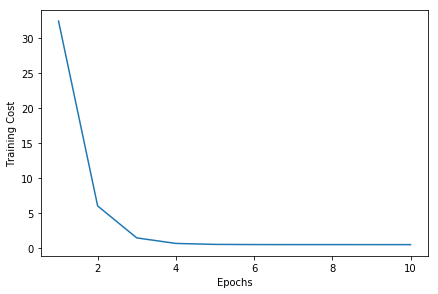

In [12]:
# モデルの収束
plt.plot(range(1,len(training_costs)+1), training_costs)
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Training Cost')
plt.show()

In [13]:
# 予測を行う関数
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X:X_test})
    return y_pred

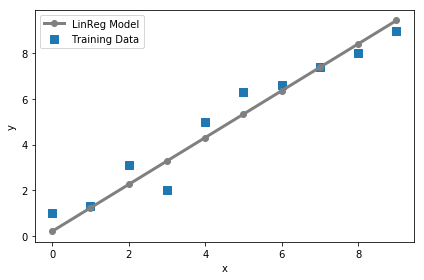

In [14]:
plt.scatter(X_train, y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]), predict_linreg(sess, lrmodel, X_train), color='gray', marker='o', markersize=6, linewidth=3, label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## 多層ニューラルネットワークの構築

In [15]:
from mnist import *

In [16]:
X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d, Columns: %d' %(X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('.', kind='t10k')
print('Rows: %d, Columns: %d' %(X_test.shape[0], X_test.shape[1]))

Rows: 60000, Columns: 784
Rows: 10000, Columns: 784


In [17]:
#標準化と規格化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val
del X_train, X_test
print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [18]:
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

In [20]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32, shape=(None,n_features), name='tf_x')
    tf_y = tf.placeholder(dtype=tf.int32, shape=None, name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    #結合層の定義
    h1 = tf.layers.dense(inputs=tf_x, units=50, activation=tf.tanh, name='layer1')
    h2 = tf.layers.dense(inputs=h1, units=50, activation=tf.tanh, name='layer2')
    logits = tf.layers.dense(inputs=h2, units=10, activation=None, name='layer3')
    predictions = {
        'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits, name='softmax_tensor')
    }

In [22]:
#コスト関数とオプティマイザの定義
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot, logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()

In [23]:
#データバッチの生成
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
    
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [24]:
#新しいTensorFlowセッションを作成
sess = tf.Session(graph=g)
sess.run(init_op)

#50エポックのトレーニング
training_costs = []
for epoch in range(50):
    training_loss = []
    batch_generator = create_batch_generator(X_train_centered, y_train, batch_size=64)
    for batch_X, batch_y in batch_generator:
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print(' -- Epoch %2d   '
              'Avg. Training Loss: %.4f' % (epoch + 1, np.mean((training_costs))))

 -- Epoch  1   Avg. Training Loss: 1.5573
 -- Epoch  2   Avg. Training Loss: 1.2532
 -- Epoch  3   Avg. Training Loss: 1.0854
 -- Epoch  4   Avg. Training Loss: 0.9738
 -- Epoch  5   Avg. Training Loss: 0.8924
 -- Epoch  6   Avg. Training Loss: 0.8296
 -- Epoch  7   Avg. Training Loss: 0.7794
 -- Epoch  8   Avg. Training Loss: 0.7381
 -- Epoch  9   Avg. Training Loss: 0.7032
 -- Epoch 10   Avg. Training Loss: 0.6734
 -- Epoch 11   Avg. Training Loss: 0.6475
 -- Epoch 12   Avg. Training Loss: 0.6247
 -- Epoch 13   Avg. Training Loss: 0.6045
 -- Epoch 14   Avg. Training Loss: 0.5864
 -- Epoch 15   Avg. Training Loss: 0.5700
 -- Epoch 16   Avg. Training Loss: 0.5551
 -- Epoch 17   Avg. Training Loss: 0.5415
 -- Epoch 18   Avg. Training Loss: 0.5290
 -- Epoch 19   Avg. Training Loss: 0.5175
 -- Epoch 20   Avg. Training Loss: 0.5068
 -- Epoch 21   Avg. Training Loss: 0.4968
 -- Epoch 22   Avg. Training Loss: 0.4875
 -- Epoch 23   Avg. Training Loss: 0.4788
 -- Epoch 24   Avg. Training Loss:

In [25]:
feed = {tf_x : X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)
print('Test Accuracy: %.2f%%' %
         (100 * np.sum(y_pred==y_test) / y_test.shape[0]))

Test Accuracy: 93.89%


## Kerasを用いた多層ニューラルネットワーク

In [26]:
import keras

Using TensorFlow backend.


In [27]:
X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d, Columns: %d' %(X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('.', kind='t10k')
print('Rows: %d, Columns: %d' %(X_test.shape[0], X_test.shape[1]))

mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val
del X_train, X_test
print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

Rows: 60000, Columns: 784
Rows: 10000, Columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [28]:
np.random.seed(123)
tf.set_random_seed(123)

In [29]:
#one-hotエンコーディング(Chapter4参照)
y_train_onehot = keras.utils.to_categorical(y_train)
print('First 3 labels: ', y_train[:3])
print('\nFirst 3 labels (one-hot):\n', y_train_onehot[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [30]:
#モデルの初期化
model = keras.models.Sequential()

In [31]:
#１つ目の隠れ層
model.add(keras.layers.Dense(units=50,
                                                      input_dim=X_train_centered.shape[1],
                                                      kernel_initializer='glorot_uniform',
                                                      bias_initializer='zeros',
                                                      activation='tanh'))
#2つ目の隠れ層
model.add(keras.layers.Dense(units=50,
                                                      input_dim=50,
                                                      kernel_initializer='glorot_uniform',
                                                      bias_initializer='zeros',
                                                      activation='tanh'))
#出力層
model.add(keras.layers.Dense(units=y_train_onehot.shape[1],
                                                      input_dim=50,
                                                      kernel_initializer='glorot_uniform',
                                                      bias_initializer='zeros',
                                                      activation='softmax'))

In [32]:
#モデルコンパイル時のオプティマイザを設定
sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=.9)

In [33]:
#モデルのコンパイル
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')

In [34]:
#モデルのトレーニング
history = model.fit(X_train_centered,
                                  y_train_onehot,
                                  batch_size=64,
                                  epochs=50,
                                  verbose=1,
                                  validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 24us/step - loss: 0.7279 - val_loss: 0.3675
Epoch 2/50
54000/54000 [==============================] - 1s 21us/step - loss: 0.3736 - val_loss: 0.2835
Epoch 3/50
54000/54000 [==============================] - 1s 20us/step - loss: 0.3080 - val_loss: 0.2451
Epoch 4/50
54000/54000 [==============================] - 1s 21us/step - loss: 0.2711 - val_loss: 0.2212
Epoch 5/50
54000/54000 [==============================] - 1s 20us/step - loss: 0.2453 - val_loss: 0.2035
Epoch 6/50
54000/54000 [==============================] - 1s 22us/step - loss: 0.2252 - val_loss: 0.1904
Epoch 7/50
54000/54000 [==============================] - 1s 21us/step - loss: 0.2090 - val_loss: 0.1800
Epoch 8/50
54000/54000 [==============================] - 1s 23us/step - loss: 0.1951 - val_loss: 0.1716
Epoch 9/50
54000/54000 [==============================] - 1s 21us/step - loss: 0.1830 - val_loss: 0.1646
Epoch 

In [35]:
#クラスラベルの予測
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [36]:
#モデルの正解率を出力
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train==y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print('First 3 predictions: ', y_train_pred[:3])
print('Training accuracy: %.2f%%' % (train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test==y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc*100))

First 3 predictions:  [5 0 4]
Training accuracy: 98.93%
Test accuracy: 96.13%
